# S&P index replication using PCA, OLS, and Lasso

In this notebook, I present three approaches to replicating the S\&P 500 index using a limited number of securities, aiming to reduce the cost of index tracking. While the study is most applicable to niche indices lacking liquid futures or ETFs, due to the scarcity of high-quality financial data, I use the S\&P 500 index as a proxy, with the expectation that results can be generalised to other equity indices.

The results slightly favour using Lasso weights to replicate the S\&P 500 index. However, the tracking error of other methods—including naïve estimators—is not significantly worse and may vary depending on the specific index and number of constituents selected.


**Disclaimer: This notebook is provided for informational and educational purposes only and does not constitute investment advice, a recommendation, or an offer to buy or sell any financial instrument.

## Data

I begin by importing composition and price data. Index composition is proxied using SPY ETF holdings, as detailed index weights typically require costly subscriptions from the provider. For benchmarking, I use total return data from the SPTR index (ticker: `^SP500TR`), as the stock price data will be adjusted for dividends. Price data is retrieved using the `yfinance` module.


In [83]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import yfinance as yf
import requests

from sklearn.decomposition import PCA
import scipy.optimize as optimize
from sklearn.linear_model import LinearRegression, LassoCV
from scipy.stats import norm, gaussian_kde
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [84]:
def get_spx_approx_weights():
    url = "https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf"
    headers = {'User-Agent': 'Mozilla/5.0'}
    holdings_url = "https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf/1467271812596.ajax?fileType=csv"
    df = pd.read_csv(holdings_url, skiprows=9)
    df = df[['Ticker', 'Weight (%)']]
    df = df.dropna()
    df.columns = ['Ticker', 'Weight']
    df['Weight'] = df['Weight'] / 100 
    df.set_index('Ticker', inplace=True)
    return pd.Series(df['Weight'])

def get_price_data(tickers: list[str], start: dt.date, end: dt.date):
    return yf.download(tickers, start=start, end=end, auto_adjust=False)['Adj Close']

In [85]:
index_ticker = "^GSPC"
start_date = dt.date(2025, 1, 1)
end_date = dt.date(2025, 7, 1)

index_compo = get_spx_approx_weights()
ticker_list = index_compo.index.to_list()
ticker_list.append(index_ticker)
df = get_price_data(ticker_list, start_date, end_date)

[*********************100%***********************]  509 of 509 completed

5 Failed downloads:
['ESU5', 'BRKB', 'BFB', 'SGAFT', 'XTSLA']: YFTzMissingError('possibly delisted; no timezone found')


In [86]:
print(f'Sum of weights: {index_compo.sum().item():.4f}')

Sum of weights: 1.0001


The sum of weights is close to one, suggesting they are reasonable. We also observe that data for five securities failed to download. Let’s examine their weights to assess whether this could be a cause for concern.

In [87]:
index_compo.loc[['SGAFT', 'ESU5', 'BFB', 'BRKB', 'XTSLA']].to_frame().style.format('{:.2%}')

,Weight
Ticker,
SGAFT,0.01%
ESU5,0.00%
BFB,0.01%
BRKB,1.64%
XTSLA,0.04%


It can be seen that, except for `BRKB`, the missing securities have negligible weights and can be safely excluded from the dataset. `BRKB` refers to Berkshire Hathaway Inc. Class B, which has a slightly different ticker on Yahoo Finance: `BRK-B`.

In [88]:
df.drop(['SGAFT', 'ESU5', 'BFB', 'XTSLA'], axis=1, inplace=True)
brkb = get_price_data('BRK-B', start_date, end_date)
df['BRKB'] = brkb

[*********************100%***********************]  1 of 1 completed


In [89]:
df.isna().any().any()

True

In [90]:
df.loc[:, df.isna().any()]

Ticker,RAL
Date,
2025-01-02,NaN
2025-01-03,NaN
2025-01-06,NaN
2025-01-07,NaN
2025-01-08,NaN
...,...
2025-06-24,NaN
2025-06-25,47.500000
2025-06-26,48.000000


In [91]:
index_compo.loc[['RAL']].to_frame().style.format('{:.2%}')

,Weight
Ticker,
RAL,0.00%


Unfortunately, the data still contains `NaN` values. However, they are limited to one minor security, which can safely be dropped from the dataset.

In [92]:
df.drop('RAL', axis=1, inplace=True)

In [93]:
df.isna().any().any()

False

The dataset is now free of `NaN` values.

## Index replication

### Naive replicators

First, I propose two naïve replication methods to serve as benchmarks for more advanced approaches:

- **Adjusted index weights**: I select the `n` names with the largest market capitalisation (which should closely reflect liquidity) and rescale their index weights to sum to one.
- **Equal weights**: Each selected name is assigned an equal weight of `1/n`.

To begin, I set `n = 50` and split the data into training and testing sets using a 50:50 proportion.

In [94]:
n = 50
train_end = dt.date(2025, 3, 31)
test_start = dt.date(2025, 4, 1)

df_train, df_test = df.loc[start_date:train_end], df.loc[test_start:end_date]

In [95]:
index_compo_sorted = index_compo.loc[df_train.columns.drop(index_ticker)].sort_values(ascending=False)
repli_names = index_compo_sorted.head(n).index
index_w = index_compo.loc[repli_names]
index_w = index_w / index_w.sum()
print(f'Sum of adj weights replication: {index_w.sum().item():.4f}')

Sum of adj weights replication: 1.0000


In [96]:
eq_w = pd.Series(np.ones(n) / n, index=repli_names)
print(f'Sum of equal weights replication: {eq_w.sum().item():.4f}')

Sum of equal weights replication: 1.0000


Next, I calculate the price series for each basket and merge them into a single dataset. This will allow for a direct comparison of returns with other replication methods and the original index.

In [97]:
index_p = df_test[index_ticker]

index_hedge_basket_p = df_test[repli_names].dot(index_w)
index_hedge_basket_p.name = 'index_w'

eq_hedge_basket_p = df_test[repli_names].dot(eq_w)
eq_hedge_basket_p.name = 'eq_w'

In [98]:
hedge_basket_p = index_p.to_frame().join(index_hedge_basket_p).join(eq_hedge_basket_p)
display(hedge_basket_p)

,^GSPC,index_w,eq_w
Date,,,
2025-04-01,5633.069824,303.031679,366.352783
2025-04-02,5670.970215,304.852844,368.477220
2025-04-03,5396.520020,290.510769,353.974864
2025-04-04,5074.080078,274.258861,334.431989
2025-04-07,5062.250000,274.021453,332.875680
...,...,...,...
2025-06-24,6092.180176,346.281424,410.111484
2025-06-25,6092.160156,346.749004,409.441726
2025-06-26,6141.020020,350.582219,414.439983


### PCA

Before fitting the PCA model, I first compute price returns on the training data. Then, I fit a correlation matrix using these returns. The SPTR total return data is excluded, as index returns are a linear combination of the returns of its constituents.

In [99]:
df_r_train = df.pct_change().dropna()[start_date:train_end]
df_r_train.drop(index_ticker, axis=1, inplace=True)
df_corr_train = df_r_train.corr()

Now, we fit a PCA.

In [100]:
pca = PCA(n_components=len(df_corr_train)).fit(df_corr_train)
components = pca.components_
factor_exposure = pd.DataFrame(components, columns = df_corr_train.columns, index=np.arange(1, len(df_corr_train) + 1))
explained_var = pca.explained_variance_ratio_
explained_var_cum = np.cumsum(explained_var)

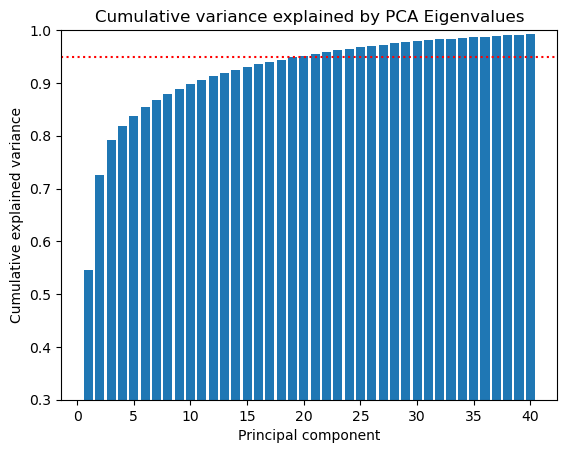

In [101]:
alpha = 0.95
n_display = 40

plt.bar(np.arange(1, n_display + 1), explained_var_cum[:n_display])
plt.axhline(y=alpha, color='red', linestyle='dotted')
plt.ylim(0.3, 1)
plt.xlabel('Principal component')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative variance explained by PCA Eigenvalues')
plt.savefig('graphs//pca_var_expli.png', dpi=300)
plt.show()

We observe that approximately 20 principal components explain 95% of the variance. Going forward, I will focus on decompositions that capture 95% of the variance to mitigate the risk of overfitting.

In [102]:
alpha = 0.95
k = np.where(explained_var_cum >= alpha)[0][0]
print(f'{k + 1} components explain {explained_var_cum[k]:.2%} of the variance')

20 components explain 95.19% of the variance


In [103]:
factor_exposure_narrow = factor_exposure.iloc[:k + 1]
explained_var_narrow = explained_var[:k + 1]
display(factor_exposure_narrow)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
1,-0.028091,-0.017254,0.059115,-0.044062,0.050916,0.037858,-0.010764,-0.033821,-0.029930,0.071967,...,0.029404,-0.028663,0.047346,0.017293,-0.016644,-0.069358,0.017905,0.052582,-0.054227,0.056515
2,0.040190,0.040253,0.029339,0.019731,0.035631,0.070269,0.040836,0.039678,0.033015,0.007075,...,0.062791,0.033208,0.057990,0.021602,0.062463,0.035735,0.044001,0.005825,0.025458,0.030480
3,-0.031312,-0.058639,0.023823,-0.024135,0.004329,0.025880,-0.036843,-0.015792,-0.036590,-0.081581,...,0.010993,-0.043562,0.060392,-0.088148,-0.043118,0.008647,0.019301,-0.059324,-0.000448,-0.007812
4,0.059976,-0.121808,-0.004885,-0.061834,0.027757,-0.031616,-0.013631,-0.016477,0.022076,0.022102,...,0.010791,0.011134,0.041253,0.046727,-0.014757,0.016957,-0.057480,0.061508,0.035769,0.023655
5,-0.047934,-0.019525,-0.036213,-0.040888,0.003806,0.047725,0.033327,-0.013355,-0.049100,-0.000221,...,-0.006925,-0.032065,0.018540,0.096001,-0.032580,0.007530,-0.117720,0.051853,0.006659,-0.004047
6,-0.059014,-0.010856,0.007253,0.013088,-0.076622,-0.001663,-0.104975,-0.031409,-0.031307,0.026715,...,0.000695,-0.029847,0.071086,0.117578,0.003857,-0.002717,0.018156,-0.011691,-0.006057,-0.058963
7,-0.027942,0.078898,0.070220,0.111722,0.076611,-0.056248,0.081356,0.028884,0.069832,-0.036356,...,-0.012364,0.032900,0.063489,0.016686,0.012126,-0.008838,-0.095739,0.061930,0.003298,0.015930
8,0.056182,-0.033093,0.051572,-0.071190,0.015041,-0.010655,-0.010440,-0.063911,0.030305,0.000071,...,-0.000943,-0.048771,0.014960,-0.085746,0.003125,0.013594,-0.081415,0.071003,0.128440,0.036791
9,0.000628,-0.048653,0.046741,-0.033712,-0.000939,0.003863,0.020381,0.024174,-0.052879,-0.078874,...,0.028234,-0.077394,0.002833,-0.009024,0.058986,-0.013329,-0.000468,0.002018,0.009801,-0.029244
10,0.118009,-0.043209,0.018448,0.044929,-0.051576,-0.022953,-0.034192,-0.001208,-0.018388,0.011349,...,0.054701,0.112537,-0.012939,-0.019347,-0.050178,0.000627,-0.076606,0.035730,0.051744,0.004783


Now, I will solve the following optimisation problem:

$
\min_w \sum_{i=0}^{k} f_i^2 \, \sigma_i^\gamma
$

subject to:

$
0 < w_j < 1 \quad \text{for each } w_j \in w
$

where:

- $f_i = w^T u_i - f_i^{\text{index}}$
- $f_i^{\text{index}} = w_{\text{index}}^T u_i$


Variables:

- $w$ is the 1 x $n$ weight vector which we try to optimise over.
- $f_i$ is the net i-th factor exposure of the hedge basket and the SPTR index.
- $\sigma_i$ is the variance explained by the i-th PCA component.
- $\gamma$ is the hyperparameter influencing how much the optimalisation focus on highly-explenative PCA components.
- $u_i$ is the 1 x $n$ vecotr of exposure to i-th PCA component (i.e. the i-th PCA eigenvector).
- $f_i^{index}$ is the SPTR index exposure to i-th PCA component.
- $w_{index}$ is the 1 x $n$ vector of index weights.

To simplify the problem, $\gamma$ will be fixed at 1 to avoid the need for hyperparameter optimisation. This choice does not significantly reduce the generality of the approach, but it helps mitigate the risk of overfitting.

In [104]:
def get_opt_w(factor_exposure: pd.DataFrame, index_factor_exposure: pd.Series, explained_var: np.array, w_init: np.array, gamma: float=1):
    min_w = 0
    max_w = 1
    weights_bound = [(min_w, max_w)] * len(w_init)
    
    def obj(w):
        f_i_sq = (factor_exposure.dot(w) - index_factor_exposure) ** 2
        sigma_pow_gamma = explained_var ** gamma
        score = (f_i_sq * sigma_pow_gamma).sum()
        return score

    opt_results = optimize.minimize(obj, w_init, bounds=weights_bound)
    return opt_results

In [105]:
repli_names = index_compo_sorted.head(n).index

index_factor_exposure_narrow = factor_exposure_narrow.dot(index_compo.loc[factor_exposure_narrow.columns])
w_init = index_compo.loc[repli_names] / index_compo.loc[repli_names].sum()

opt_results = get_opt_w(factor_exposure_narrow[repli_names], index_factor_exposure_narrow, explained_var_narrow, w_init, gamma=1)
pca_w = pd.Series(opt_results.x, index=repli_names)

In [106]:
print(f'Sum of PCA weights replication: {pca_w.sum().item():.4f}')

Sum of PCA weights replication: 1.0425


The sum of weights is very close to one, despite not being explicitly constrained. Now, I will rescale the weights so that they sum exactly to one.

In [107]:
pca_w = pca_w / pca_w.sum()

Now, let's examine how the PCA exposures of the replication basket compare to those of the index after optimisation.

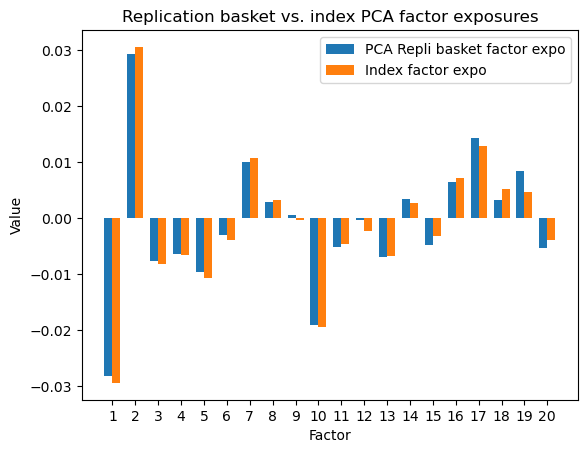

In [108]:
pca_basket_expo = factor_exposure_narrow[repli_names].dot(pca_w)
width = 0.35

fig, ax = plt.subplots()

ax.bar(pca_basket_expo.index - width / 2, pca_basket_expo, width, label='PCA Repli basket factor expo')
ax.bar(index_factor_exposure_narrow.index + width / 2, index_factor_exposure_narrow, width, label='Index factor expo')

ax.set_title('Replication basket vs. index PCA factor exposures')
ax.set_xlabel('Factor')
ax.set_ylabel('Value')
ax.legend()

ax.set_xticks(pca_basket_expo.index)
ax.set_xticklabels(pca_basket_expo.index)

plt.savefig('graphs//pca_basket_expo.png', dpi=300)
plt.show()

Finally, I calculate the price series for the PCA-based replication basket and add it to the overall price dataset.

In [109]:
pca_hedge_basket_p = df_test[repli_names].dot(pca_w)
pca_hedge_basket_p.name = 'pca_w'
hedge_basket_p = hedge_basket_p.join(pca_hedge_basket_p)

### OLS

Now, I fit an OLS regression of SPTR index returns on the returns of its components, using the resulting coefficients as replication basket weights. The regression is constrained to have only positive coefficients (as short positions are undesirable) and is fitted without an intercept.

In [110]:
repli_names = index_compo_sorted.head(n).index

df_r_train = df.pct_change().dropna()[start_date:train_end]
y_train, x_train = df_r_train[index_ticker], df_r_train[repli_names]

In [111]:
model_ols = LinearRegression(fit_intercept=False, positive=True).fit(x_train, y_train)
ols_w = pd.Series(model_ols.coef_, index=repli_names)

In [112]:
print(f'Sum of OLS weights: {ols_w.sum().item():.4f}')

Sum of OLS weights: 0.9700


Again, sum of weights is close enough to 1 so we can re-scale it to sum up to 1. 

In [113]:
ols_w = ols_w / ols_w.sum()

Next, I calculate the price series of the OLS-based hedge basket and add it to the dataset.

In [114]:
ols_hedge_basket_p = df_test[repli_names].dot(ols_w)
ols_hedge_basket_p.name = 'ols_w'
hedge_basket_p = hedge_basket_p.join(ols_hedge_basket_p)

### Lasso

Finally, I replicate the index using Lasso regression, with the regularisation hyperparameter selected via cross-validation. Unlike the previous two techniques, I do not specify the size or structure of the replicating basket, as coefficients with limited explanatory power are automatically shrunk to zero.

In [115]:
init_names = index_compo_sorted.index
df_r_train = df.pct_change().dropna()[start_date:train_end]
y_train, x_train = df_r_train[index_ticker], df_r_train[init_names]

In [116]:
model_lasso = LassoCV(fit_intercept=False, positive=True).fit(x_train, y_train)
lasso_w = pd.Series(model_lasso.coef_, index=init_names)

In [117]:
print(f'Sum of Lasso weights: {lasso_w.sum().item():.4f}')
print(f'Number of non-zero Lasso weights: {len(lasso_w[lasso_w > 0])}')

Sum of Lasso weights: 0.6949
Number of non-zero Lasso weights: 63


This time, the sum of the Lasso weights deviates notably from one, which may be a slight concern. However, the model results in only 63 non-zero weights, which is a strong outcome given the original universe of over 500 securities.

In [118]:
lasso_w = lasso_w / lasso_w.sum()

In [119]:
lasso_hedge_basket_p = df_test[init_names].dot(lasso_w)
lasso_hedge_basket_p.name = 'lasso_w'
hedge_basket_p = hedge_basket_p.join(lasso_hedge_basket_p)

## Model check

### Residual distribution

In [120]:
hedge_basket_ret = hedge_basket_p.pct_change().dropna()

#### Index weights

In [121]:
index_repli_resid = hedge_basket_ret['index_w'] - hedge_basket_ret[index_ticker]

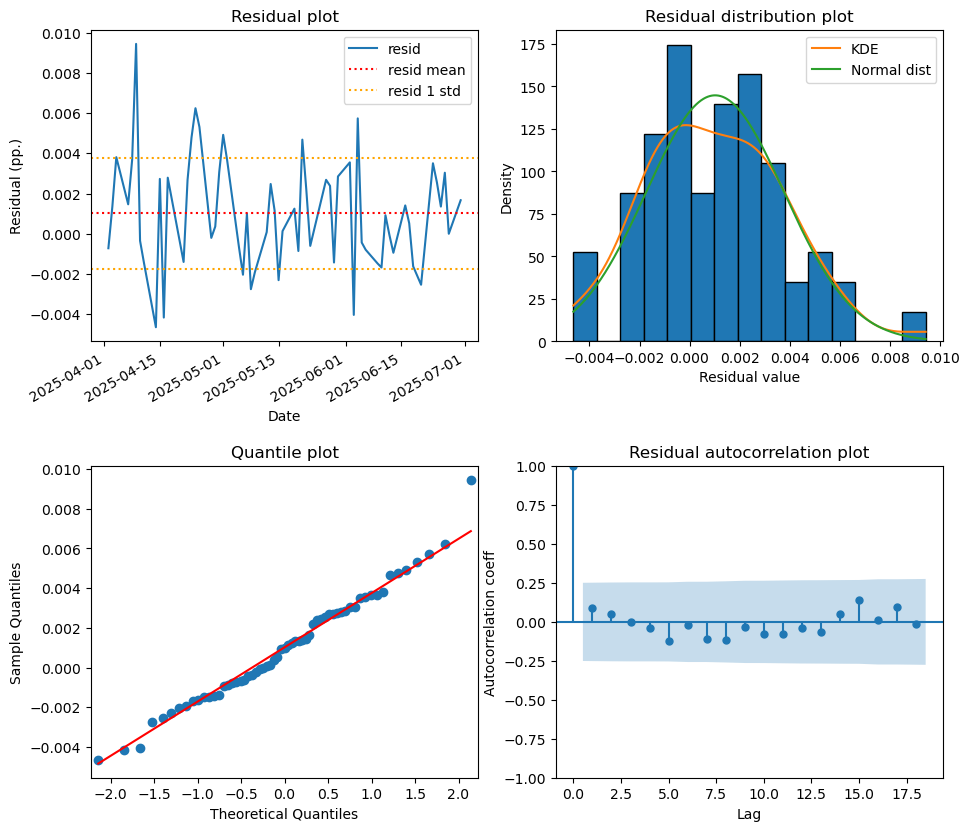

In [122]:
def plot_resid_check(resid: pd.Series, save_path: str):
    fig = plt.figure(figsize=(11, 11))
    
    #Resid plot
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(resid, label='resid')
    ax1.axhline(y=resid.mean(), color='red', linestyle='dotted', label='resid mean')
    ax1.axhline(y=resid.mean() + resid.std(), color='orange', linestyle='dotted', label='resid 1 std')
    ax1.axhline(y=resid.mean() - resid.std(), color='orange', linestyle='dotted')
    ax1.legend()

    fig.autofmt_xdate()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residual (pp.)')
    ax1.set_title('Residual plot')
    
    #Histo plot
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.hist(resid, bins=15, edgecolor='black', density=True)
    kde = gaussian_kde(resid)
    xlin = np.linspace(min(resid), max(resid), 1000)
    kde_vals = kde(xlin)
    norm_vals = norm.pdf(xlin, resid.mean(), resid.std())
    ax2.plot(xlin, kde_vals, label="KDE")
    ax2.plot(xlin, norm_vals, label="Normal dist")
    ax2.legend()
    ax2.set_xlabel('Residual value')
    ax2.set_ylabel('Density')
    ax2.set_title('Residual distribution plot')
    
    #QQPlot
    ax3 = fig.add_subplot(2, 2, 3)
    qqplot(resid, line='s', ax=ax3)
    ax3.set_title('Quantile plot')
    
    #Autocorr plot
    ax4 = fig.add_subplot(2, 2, 4)
    plot_acf(resid, ax=ax4)
    ax4.set_title('Residual autocorrelation plot')
    ax4.set_xlabel('Lag')
    ax4.set_ylabel('Autocorrelation coeff')

    plt.subplots_adjust(hspace=0.4)
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_resid_check(index_repli_resid, 'graphs//index_w_residcheck.png')

#### Equal weights

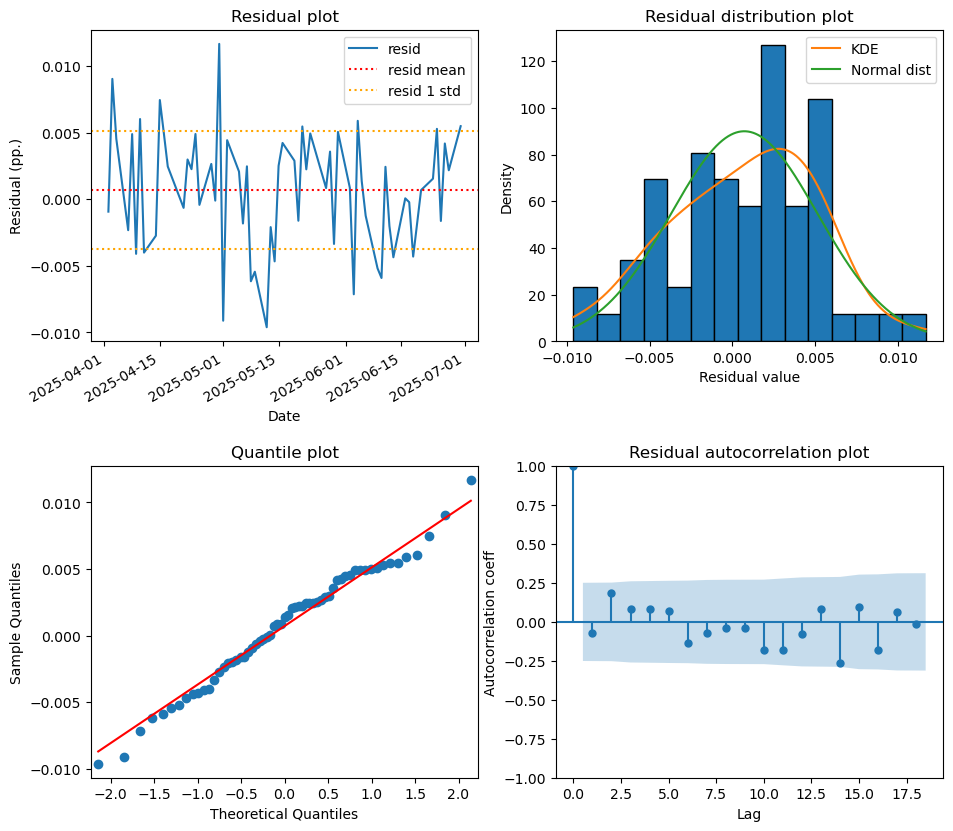

In [123]:
eq_repli_resid = hedge_basket_ret['eq_w'] - hedge_basket_ret[index_ticker]
plot_resid_check(eq_repli_resid, 'graphs//eq_w_residcheck.png')

#### PCA

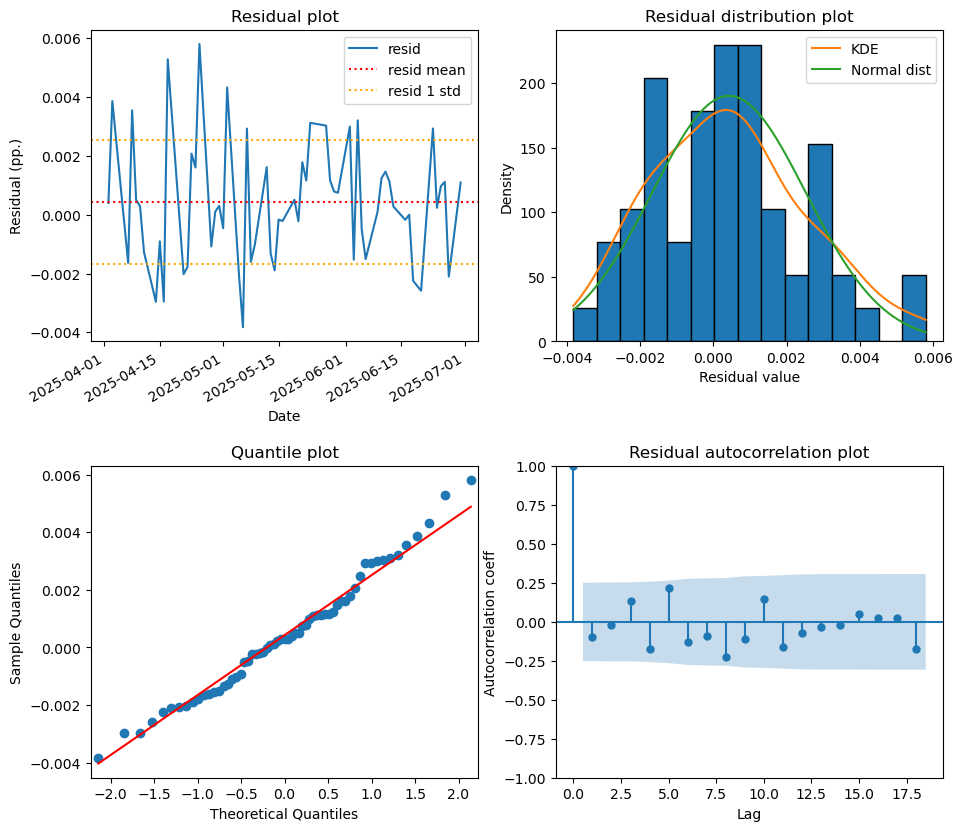

In [124]:
pca_repli_resid = hedge_basket_ret['pca_w'] - hedge_basket_ret[index_ticker]
plot_resid_check(pca_repli_resid, 'graphs//pca_w_residcheck.png')

#### OLS

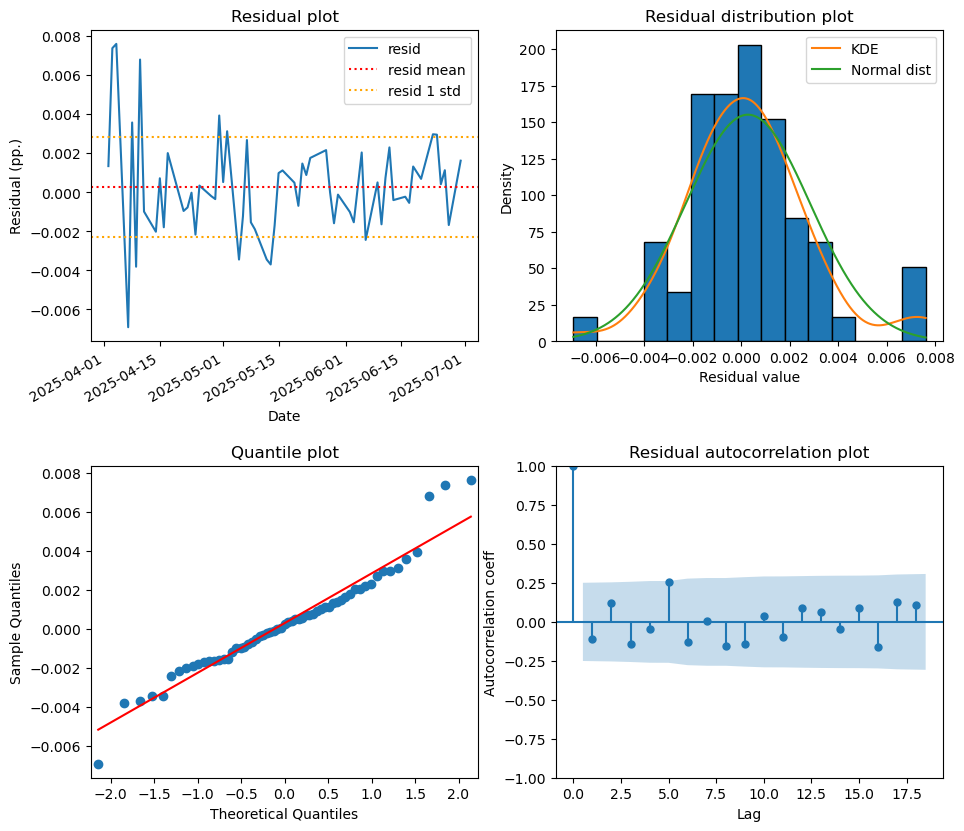

In [125]:
ols_repli_resid = hedge_basket_ret['ols_w'] - hedge_basket_ret[index_ticker]
plot_resid_check(ols_repli_resid, 'graphs//ols_w_residcheck.png')

#### Lasso

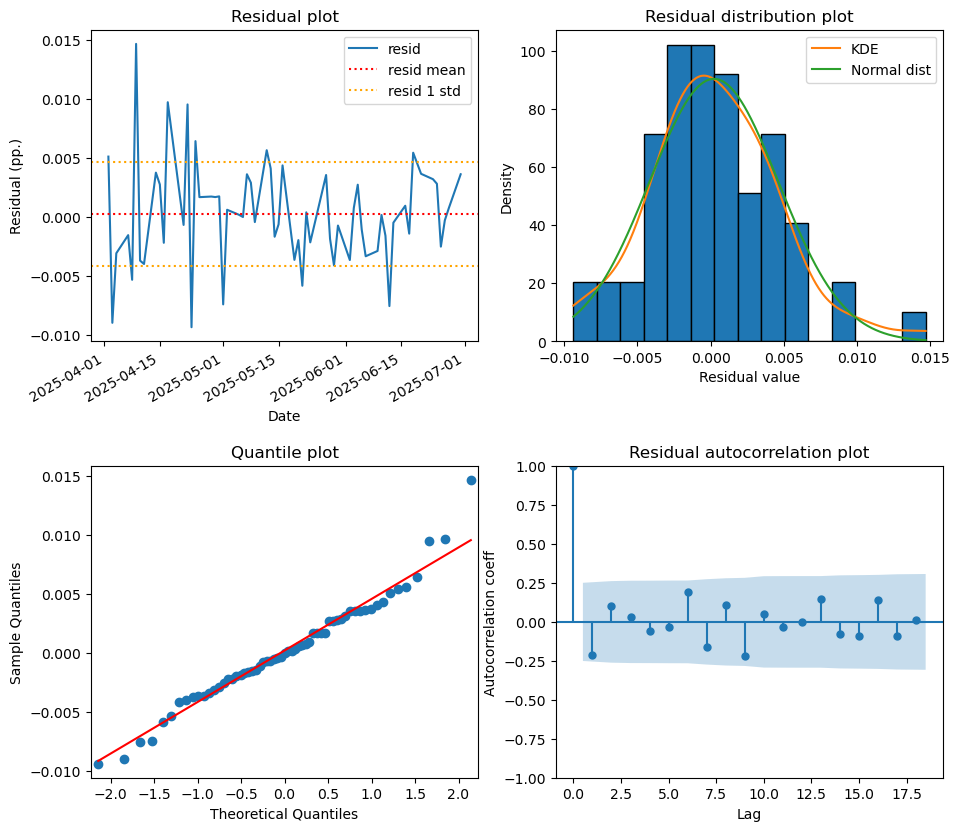

In [126]:
lasso_repli_resid = hedge_basket_ret['lasso_w'] - hedge_basket_ret[index_ticker]
plot_resid_check(lasso_repli_resid, 'graphs//lasso_w_residcheck.png')

As shown in the charts above, residuals from most methods are well-behaved, except for those from the OLS model, which exhibit a slight fat-tailed behaviour—an indication of potential overfitting. This is not surprising, as both the PCA-based optimisation and Lasso regression are specifically designed to mitigate overfitting.

### Pseudo R-squared

In [127]:
def get_pseudo_r2(y: pd.Series, y_hat: pd.Series):
    tss = ((y - y.mean()) ** 2).sum()
    rss = ((y - y_hat) ** 2).sum()
    return 1 - (rss / tss)

r2_index_repli = get_pseudo_r2(hedge_basket_ret[index_ticker], hedge_basket_ret['index_w'])
r2_eq_repli = get_pseudo_r2(hedge_basket_ret[index_ticker], hedge_basket_ret['eq_w'])
r2_pca_repli = get_pseudo_r2(hedge_basket_ret[index_ticker], hedge_basket_ret['pca_w'])
r2_ols_repli = get_pseudo_r2(hedge_basket_ret[index_ticker], hedge_basket_ret['ols_w'])
r2_lasso_repli = get_pseudo_r2(hedge_basket_ret[index_ticker], hedge_basket_ret['lasso_w'])

r2_df = pd.DataFrame([r2_index_repli, r2_eq_repli, r2_pca_repli, r2_ols_repli, r2_lasso_repli],
                     index=['Index weight', 'Equal weight', 'PCA weight', 'OLS weight', 'Lasso weight'],
                     columns=['Pseudo R-squared']
                    )
display(r2_df.style.format('{:.2%}').highlight_max(axis=0, color='green').highlight_min(axis=0, color='red'))

,Pseudo R-squared
Index weight,97.68%
Equal weight,94.59%
PCA weight,98.77%
OLS weight,98.20%
Lasso weight,94.77%


All replication methods perform strongly out-of-sample, with pseudo R-squared values exceeding 95%. The highest is observed for the PCA replication approach, reaching 99%. Let’s now examine how this translates into tracking error.

### Tracking error

In [128]:
hedge_basket_cumret = (1 + hedge_basket_ret).cumprod()

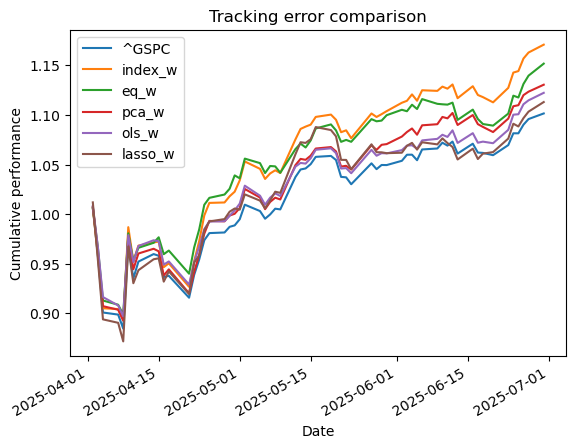

In [129]:
ax = hedge_basket_cumret.plot(xlabel='Date', ylabel='Cumulative performance', title='Tracking error comparison')
plt.savefig('graphs//track_error_plot.png', dpi=300)
plt.show()

In [130]:
hedge_basket_trackerror = hedge_basket_cumret.drop(index_ticker, axis=1).sub(hedge_basket_cumret[index_ticker], axis=0).abs()

In [131]:
trackerror_final = hedge_basket_trackerror.iloc[-1]
trackerror_final.name = 'Final abs TE'
trackerror_avg = hedge_basket_trackerror.mean()
trackerror_avg.name = 'Average abs TE'
trackerror_median = hedge_basket_trackerror.median()
trackerror_median.name = 'Median abs TE'
trackerror_max = hedge_basket_trackerror.max()
trackerror_max.name = 'Max abs TE'

df_trackerror = trackerror_final.to_frame().join(trackerror_avg).join(trackerror_median).join(trackerror_max)
df_trackerror.index = ['Index weight', 'Equal weight', 'PCA weight', 'OLS weight', 'Lasso weight']
display(df_trackerror.style.format('{:.2%}').highlight_min(axis=0, color='green').highlight_max(axis=0, color='red'))

,Final abs TE,Average abs TE,Median abs TE,Max abs TE
Index weight,6.94%,3.96%,4.17%,6.94%
Equal weight,5.02%,3.39%,3.57%,5.16%
PCA weight,2.90%,1.53%,1.17%,2.98%
OLS weight,2.08%,1.21%,1.16%,2.08%
Lasso weight,1.15%,1.10%,0.97%,3.00%


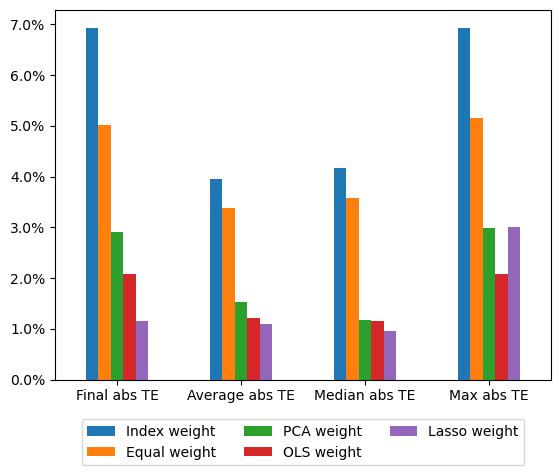

In [132]:
ax = (df_trackerror * 100).T.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('graphs//track_error_bar.png', dpi=300, bbox_inches='tight')
plt.show()

Interestingly, the OLS method yields the lowest tracking error across nearly all categories, while index-weight replication results in the highest. However, the median and average tracking errors for the PCA and Lasso replications are not far behind, indicating comparable performance.

### Weights comparison

In [133]:
index_w.name = 'index_w'
eq_w.name = 'eq_w'
pca_w.name = 'pca_w'
ols_w.name = 'ols_w'
lasso_w.name = 'lasso_w'

w_df = index_w.to_frame().join(eq_w).join(pca_w).join(ols_w).join(lasso_w)
display(w_df.head(20).style.format('{:.2%}'))

,index_w,eq_w,pca_w,ols_w,lasso_w
Ticker,,,,,
NVDA,12.90%,2.00%,11.96%,6.57%,0.00%
MSFT,11.62%,2.00%,8.80%,11.28%,0.00%
AAPL,9.73%,2.00%,6.42%,5.57%,9.83%
AMZN,6.65%,2.00%,5.66%,3.47%,3.89%
META,4.71%,2.00%,3.49%,0.00%,0.86%
AVGO,4.16%,2.00%,4.77%,3.25%,0.00%
GOOGL,3.42%,2.00%,1.69%,1.27%,2.06%
GOOG,2.77%,2.00%,1.18%,0.00%,0.27%
BRKB,2.71%,2.00%,3.82%,5.90%,0.00%


As clearly can be seen, each replication method is unique, yeilding disting hedge basket weights.